# Initialize Environment

In [1]:
# !pip install image-classifiers==1.0.0b1
# # from classification_models.tfkeras import Classifiers

In [2]:
!pip install -q efficientnet >> /dev/null
!pip install colorama
import tensorflow_addons as tfa
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.
* M1 - is a list of length EXPERIMENTS. For each experiment, choose 0, 1, 2, 3, etc. Determines how many additional copies of malignant images from this years comp data to add
* M2 - is a list. Adds copies of malignant images from ISIC archive that are not in 2020, 2019, 2018, 2017 comp data
* M3 - is a list. Adds copies of malignant images from 2019 comp data. They have been filtered to include the ones that look like 2020 data
* M4 - is a list. Adds copies of malignant images from 2018 2017 data.

In [3]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 3

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384] * FOLDS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0] * FOLDS
INC2018 = [1] * FOLDS

# UPSAMPLE MALIGNANT COUNT TIMES
M1 = [0]* FOLDS #2020 malig
M2 = [0]* FOLDS #ISIC malig
M3 = [1]* FOLDS #2019 good malig
M4 = [0]* FOLDS #2018 2017 malig

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [20]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [5] * FOLDS

# COARSE DROPOUT
DROP_FREQ = [0]*FOLDS # between 0 and 1
DROP_CT = [0]*FOLDS # may slow training if CT>16
DROP_SIZE = [0]*FOLDS # between 0 and 1

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 25

# CHECKPOINTS
ModelCheckpoint = True
CSVLogger = True
Rampup_Decay = True
Cosine_Schedule = False
CUTOUT = True
# LOSS [ BinaryCrossentropy == True , Focal Loss == False ]
BCE = False 

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [5]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS; GCS_PATH3 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES[:FOLDS]):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
    GCS_PATH3[i] = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

In [6]:
print(GCS_PATH[0])
print(GCS_PATH2[0])
print(GCS_PATH3[0])

gs://kds-af04201ad3b23ab44fccef46bc878e212bf0799d4ab8511bb65cc598
gs://kds-6a5a4659ad497a6521a7673de8db35f824381c90bfb0ba83ee7b72a7
gs://kds-521ff7286dd816fd4882792049e635e4da081f8f1fde1f5d0d1f3af8


# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [7]:
ROT_ = 90.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [8]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

## Cutout

In [9]:
def getCutout(image,PROBABILITY=1.0,DIM = 256):
    
    # DO CUTOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
    
    # CHOOSE RANDOM LOCATION
    x = tf.cast( tf.random.uniform([],DIM/4,3*DIM/4),tf.int32)
    y = tf.cast( tf.random.uniform([],DIM/4,3*DIM/4),tf.int32)
    
    b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
    
    WIDTH = tf.cast( DIM/4 * tf.math.sqrt(1-b),tf.int32) * P
    ya = tf.math.maximum(0,y-WIDTH//2)
    yb = tf.math.minimum(DIM,y+WIDTH//2)
    xa = tf.math.maximum(0,x-WIDTH//2)
    xb = tf.math.minimum(DIM,x+WIDTH//2)
    
    # MAKE CUTOUT IMAGE
#     image[ya:yb,xa:xb,:] = 0.0
    
    one = image[ya:yb,0:xa,:]
    two = tf.zeros([yb-ya,xb-xa,3])
#     two = tf.random.uniform([yb-ya,xb-xa,3],0,0.9)
    three = image[ya:yb,xb:DIM,:]
    middle = tf.concat([one,two,three],axis=1)
    result_image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
    
    return result_image

## Coarse-droapout

In [10]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

## Read Tfrecords

In [11]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256, droprate=0, dropct=0, dropsize=0):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
            
        img = tf.image.random_flip_left_right(img)
        img =  tf.image.random_flip_up_down(img)
        
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        
        if CUTOUT:
            img = getCutout(img,PROBABILITY=0.75,DIM = dim)
            
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [12]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256,
                droprate=0, dropct=0, dropsize=0):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2) #if too large causes OOM in GPU CPU
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (
                prepare_image(img, augment=augment, dim=dim, 
                              droprate=droprate, dropct=dropct, dropsize=dropsize), 
                imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [13]:
# def binary_focal_loss(gamma=1.0, alpha=0.8):
#     """
#     Binary form of focal loss.
#       FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
#       where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
#     References:
#         https://arxiv.org/pdf/1708.02002.pdf
#     Usage:
#      model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
#     """
#     def binary_focal_loss_fixed(y_true, y_pred):
#         """
#         :param y_true: A tensor of the same shape as `y_pred`
#         :param y_pred:  A tensor resulting from a sigmoid
#         :return: Output tensor.
#         """
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         epsilon = K.epsilon()
#         # clip to prevent NaN's and Inf's
#         pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
#         pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
#                -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

#     return binary_focal_loss_fixed

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [14]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    if BCE:
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    else: 
#         loss = [binary_focal_loss()]
        loss = tfa.losses.SigmoidFocalCrossEntropy(gamma=1.0,alpha=0.8)
        
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

# Rampup decy lr Schedule

In [15]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Cyclic Learning Rate

In [16]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified version of the get_cosine_schedule_with_warmup from huggingface.
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

LR = 0.0001
WARMUP = 6

## GET_Rank

In [17]:
from scipy.stats import rankdata
def getRanks(x):
    y = x
    for i,col in enumerate(x.T):
        y.T[i] = rankdata(col)/rankdata(col).max()
    return y

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B5 and batch_size 32 loss= Focal Loss
#### Using 2018+2017 external data
#### Upsample MALIG-3 data (2019 comp)
#########################
115515392/115515256 [==============================] - 4s 0us/step
Training...
Epoch 1/20
121/121 [==============================] - 110s 907ms/step - auc: 0.6241 - loss: 0.0758 - val_auc: 0.5475 - val_loss: 0.0531 - lr: 5.0000e-06
Epoch 2/20
121/121 [==============================] - 81s 673ms/step - auc: 0.8592 - loss: 0.0479 - val_auc: 0.8307 - val_loss: 0.0216 - lr: 6.8000e-05
Epoch 3/20
121/121 [==============================] - 81s 673ms/step - auc: 0.9088 - loss: 0.0389 - val_auc: 0.8772 - val_loss: 0.0215 - lr: 1.3100e-04
Epoch 4/20
121/121 [==============================] - 81s 672ms/step - auc: 0.9228 - loss: 0.0362 - val_auc: 0.8871 - val_loss: 0.0197 - lr: 1.9400e-04
Epoch 5/20
121/121 [==============================] - 78s 648ms/step - auc: 0.9297 - loss: 0.0346 

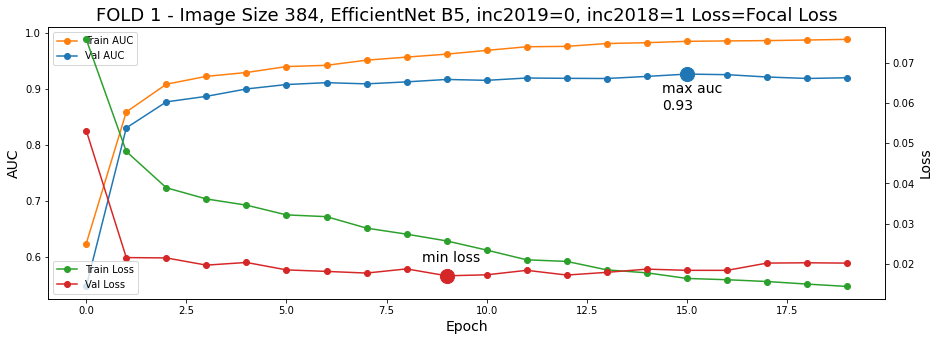

#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B5 and batch_size 32 loss= Focal Loss
#### Using 2018+2017 external data
#### Upsample MALIG-3 data (2019 comp)
#########################
Training...
Epoch 1/20
121/121 [==============================] - 110s 909ms/step - auc: 0.6782 - loss: 0.0750 - val_auc: 0.6169 - val_loss: 0.0507 - lr: 5.0000e-06
Epoch 2/20
121/121 [==============================] - 84s 690ms/step - auc: 0.8441 - loss: 0.0502 - val_auc: 0.8472 - val_loss: 0.0206 - lr: 6.8000e-05
Epoch 3/20
121/121 [==============================] - 84s 691ms/step - auc: 0.9056 - loss: 0.0401 - val_auc: 0.8960 - val_loss: 0.0180 - lr: 1.3100e-04
Epoch 4/20
121/121 [==============================] - 84s 690ms/step - auc: 0.9193 - loss: 0.0372 - val_auc: 0.9153 - val_loss: 0.0166 - lr: 1.9400e-04
Epoch 5/20
121/121 [==============================] - 85s 699ms/step - auc: 0.9277 - loss: 0.0351 - val_auc: 0.9175 - val_loss: 0.0166 - lr: 2.5700e-04
Epoch 6/20
12

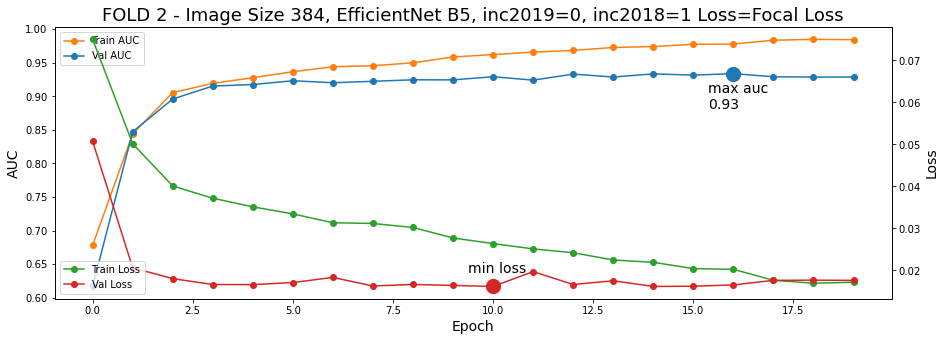

#########################
#### FOLD 3
#### Image Size 384 with EfficientNet B5 and batch_size 32 loss= Focal Loss
#### Using 2018+2017 external data
#### Upsample MALIG-3 data (2019 comp)
#########################
Training...
Epoch 1/20
121/121 [==============================] - 111s 914ms/step - auc: 0.6818 - loss: 0.0754 - val_auc: 0.6168 - val_loss: 0.0590 - lr: 5.0000e-06
Epoch 2/20
121/121 [==============================] - 84s 690ms/step - auc: 0.8587 - loss: 0.0481 - val_auc: 0.8499 - val_loss: 0.0203 - lr: 6.8000e-05
Epoch 3/20
121/121 [==============================] - 84s 693ms/step - auc: 0.9051 - loss: 0.0394 - val_auc: 0.8981 - val_loss: 0.0186 - lr: 1.3100e-04
Epoch 4/20
121/121 [==============================] - 84s 695ms/step - auc: 0.9199 - loss: 0.0365 - val_auc: 0.9019 - val_loss: 0.0179 - lr: 1.9400e-04
Epoch 5/20
121/121 [==============================] - 84s 697ms/step - auc: 0.9354 - loss: 0.0332 - val_auc: 0.9092 - val_loss: 0.0174 - lr: 2.5700e-04
Epoch 6/20
12

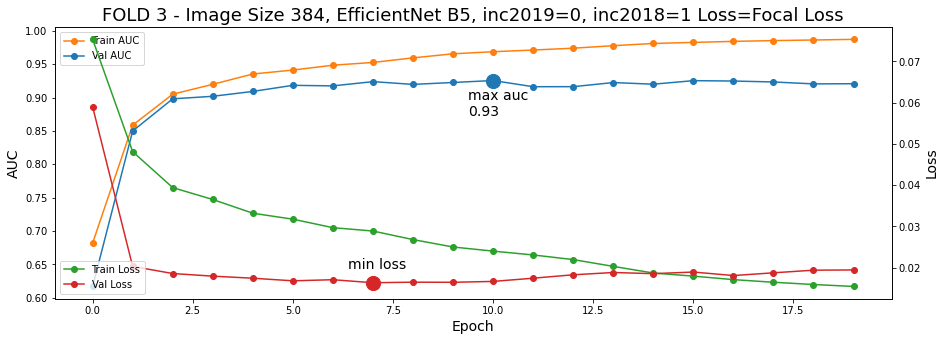

In [18]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
oof_pred_rank = []
preds = np.zeros((count_data_items(files_test),1))
preds_rank = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
#     if fold != train_fold:
#         continue
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    if BCE:
        p_loss = 'BinaryCrossentropy'
    else:
        p_loss = 'Focal Loss'
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i loss= %s'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold],p_loss))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    for k in range(M1[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsample MALIG-1 data (2020 comp)')
    for k in range(M2[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Upsample MALIG-2 data (ISIC website)')
    for k in range(M3[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
        print('#### Upsample MALIG-3 data (2019 comp)')
    for k in range(M4[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsample MALIG-4 data (2018 2017 comp)')
    np.random.shuffle(files_train)
    print('#'*25)
    
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    call_backs = []
    
    # SAVE BEST MODEL EACH FOLD
    if ModelCheckpoint:   
        sv1 = tf.keras.callbacks.ModelCheckpoint(
            'auc-fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
            save_weights_only=True, mode='max', save_freq='epoch')
        call_backs.append(sv1)
        
        sv2 = tf.keras.callbacks.ModelCheckpoint(
            'loss-fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
            save_weights_only=True, mode='min', save_freq='epoch')
        call_backs.append(sv2)
        
    # csv_logger
    if CSVLogger:
        csv_logger = tf.keras.callbacks.CSVLogger('fold_%i_log.csv'%fold, separator=',', append=False)
        call_backs.append(csv_logger)
    
    # rampup decy lr schedule
    if Rampup_Decay:
        lr_schedule = get_lr_callback(BATCH_SIZES[fold])
        call_backs.append(lr_schedule)
        
    #cosine Callback
    if Cosine_Schedule:
        lr_schedule= get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS[fold])
        call_backs.append(lr_schedule)
        
    # Training Data
    training_data = get_dataset(files_train, augment=True, 
                                shuffle=True, repeat=True,
                                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold],
                                droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], 
                                dropsize=DROP_SIZE[fold])
    # Validation Data
    validation_data=get_dataset(files_valid,
                                augment=False,
                                shuffle=False,
                                repeat=False,
                                dim=IMG_SIZES[fold],
                                batch_size = BATCH_SIZES[fold])
        
    # TRAIN MODEL
    print('Training...')
    history = model.fit(training_data, 
                        epochs=EPOCHS[fold], 
                        callbacks = call_backs, 
                        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                        validation_data = validation_data, 
                        #class_weight = {0:1,1:2},
                        verbose=VERBOSE)
    
    print(Fore.GREEN,'Loading best model...MAX VAL_AUC')
    model.load_weights('auc-fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...MAX VAL_AUC')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_valid = count_data_items(files_valid)
    STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    pred_reshape = pred.reshape((ct_valid,TTA),order='F')
    oof_pred.append( np.mean(pred_reshape,axis=1) )                 
    oof_pred_rank.append( np.mean(getRanks(pred_reshape),axis=1) )     


    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...MAX VAL_AUC',Style.RESET_ALL)
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    pred_reshape = pred.reshape((ct_test,TTA),order='F')
    preds[:,0] += np.mean(pred_reshape,axis=1) * WGTS[fold]
    preds_rank[:,0] += np.mean(getRanks(pred_reshape),axis=1) * WGTS[fold]
    
    
    print(Fore.CYAN ,'Loading best model loss-fold-%i.h5...MIN VAL_LOSS'%fold)
    model.load_weights('loss-fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...MIN VAL_LOSS')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_valid = count_data_items(files_valid)
    STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    pred_reshape = pred.reshape((ct_valid,TTA),order='F')
    oof_pred.append( np.mean(pred_reshape,axis=1) )                 
    oof_pred_rank.append( np.mean(getRanks(pred_reshape),axis=1) )     


    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...MIN VAL_LOSS',Style.RESET_ALL)
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    pred_reshape = pred.reshape((ct_test,TTA),order='F')
    preds[:,0] += np.mean(pred_reshape,axis=1) * WGTS[fold]
    preds_rank[:,0] += np.mean(getRanks(pred_reshape),axis=1) * WGTS[fold]

    # REPORT RESULTS
    auc_rank = roc_auc_score(oof_tar[-1],oof_pred_rank[-1])
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f , with TTA_rank = %.3f'%(fold+1,oof_val[-1],auc,auc_rank))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i Loss=%s'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold],p_loss),size=18)
        plt.legend(loc=3)
        plt.savefig('fold_%i.png'%fold)
        plt.show()  

## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [19]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
oof_rank = np.concatenate(oof_pred_rank)
auc = roc_auc_score(true,oof)
auc_rank = roc_auc_score(true,oof_rank)
print('Overall OOF AUC with TTA = %.3f'%auc)
print('Overall OOF AUC with TTA_rank = %.3f'%auc_rank)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.930
Overall OOF AUC with TTA_rank = 0.933


,image_name,target,pred,fold
0,ISIC_2637011,0,0.009799,0
1,ISIC_0082348,0,0.013049,0
2,ISIC_0076262,0,0.043316,0
3,ISIC_0074268,0,0.003103,0
4,ISIC_0079038,0,0.000650,0


In [20]:
# SAVE OOF TO DISK
df_oof_rank = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof_rank, fold=folds))
df_oof_rank.to_csv('oof_rank.csv',index=False)
df_oof_rank.head()

,image_name,target,pred,fold
0,ISIC_2637011,0,0.305194,0
1,ISIC_0082348,0,0.391705,0
2,ISIC_0076262,0,0.644045,0
3,ISIC_0074268,0,0.143257,0
4,ISIC_0079038,0,0.020964,0


# Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

# Submit To Kaggle

In [21]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [22]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.031475
1443,ISIC_0052349,0.046338
3120,ISIC_0058510,0.031752
4870,ISIC_0073313,0.024500
5494,ISIC_0073502,0.054781


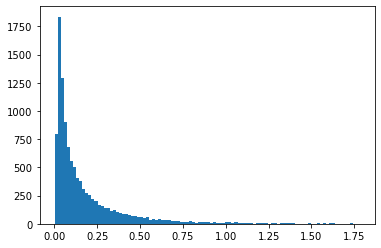

In [23]:
plt.hist(submission.target,bins=100)
plt.show()

In [24]:
submission_rank = pd.DataFrame(dict(image_name=image_names, target=preds_rank[:,0]))
submission_rank = submission_rank.sort_values('image_name') 
submission_rank.to_csv('submission_rank.csv', index=False)
submission_rank.head()

,image_name,target
9905,ISIC_0052060,0.476916
1443,ISIC_0052349,0.703817
3120,ISIC_0058510,0.507164
4870,ISIC_0073313,0.417945
5494,ISIC_0073502,0.671755


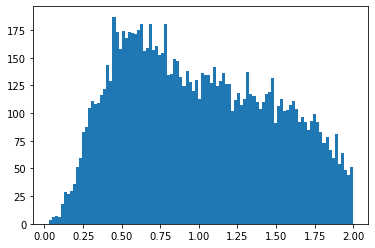

In [25]:
plt.hist(submission_rank.target,bins=100)
plt.show()

In [26]:
# 